# Detect Trucks Sentinel-2 - Europe
________________                                            

In [4]:
# load creds
%load_ext dotenv
%dotenv

In [765]:
# general
import os
from datetime import date, datetime
import pandas as pd

# OSM API
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

# xcube
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube.core.maskset import MaskSet

# spatial
import geopandas as gpd
from shapely import geometry, coords
#from osgeo import gdal #, gdal_array, ogr
from pyproj import crs, Transformer

# plotting
import matplotlib as plt
import IPython.display
%matplotlib inline

#### Directories

In [71]:
dir_main = os.getcwd()
dir_not_commit = os.path.join(dir_main, "not_commit")
dir_ancil = os.path.join(dir_not_commit, "ancillary_data")
dirs = {"dir":dir_main, "dir_not_commit":dir_not_commit, "ancil":dir_ancil, "processing":os.path.join(dir_main, "processing"),
       "processed":os.path.join(dir_not_commit, "processed"), "ancil_roads":os.path.join(dir_ancil, "roads")}
for directory in list(dirs.values()):
    if not os.path.exists(directory): os.mkdir(directory)

________________
## Parameters

#### General

In [455]:
dataset = "S2L2A"
spatial_res = 0.00009 # 10m
band_names = ["B02", "B03", "B04", "B08", "B11", "SCL"]
time_period = "1D"

#### Temporal

In [456]:
covid19 = {"first":datetime(2020, 3, 16), "last":datetime(2020, 6, 6)}
baseline = {"first":datetime(2017, 1, 1), "last":datetime(2020, 3, covid19_start.day - 1)}

#### OSM

In [459]:
osm_keys = ["motorway", "trunk", "primary", "secondary", "tertiary"]

________________
## Utils

#### CRS

In [587]:
def EPSG_4326(): return "EPSG:4326"
def EPSG_3857(): return "EPSG:3857"

#### Vectors

In [461]:
def GEOJSON(): return "GeoJSON"

In [719]:
def get_gpd_geom(gdf):
    return gdf.geometry.apply(lambda geom: geom.coords)

In [751]:
# coords List of tuple yx coordinates
# src_crs String EPSG:CODE source
# tgt_crs String EPSG:CODE target
def reproj_coords(coords, src_crs, tgt_crs):
    src = crs.CRS(src_crs)
    tgt = crs.CRS(tgt_crs)
    tf = Transformer.from_crs(src, tgt)
    return tf.transform(xx = coords[1], yy = coords[0])

In [752]:
# lines GeoDataFrame of line features
# dist Float buffer distance [m]

# reproject to use meters
#lines_epsg3857 = lines.to_crs("EPSG:3857") # unfortunately problem with this
geom = get_gpd_geom(lines)
geom_epsg3857 = []
for i in range(len(geom)):
    line = list(geom[i])
    line_epsg3857 = []
    for yx in line:
        yx_epsg3857 = reproj_coords(yx, EPSG_4326(), EPSG_3857())
        line_epsg3857.append(yx_epsg3857)
    geom_epsg3857.append(coords.CoordinateSequence(line_epsg3857))
lines_epgs3857 = lines.copy()
lines_epgs3857.geometry = gpd.geoseries.GeoSeries() 
#buff = lines_epsg3857.geometry.buffer(dist)

NameError: name 'line_new' is not defined

In [795]:
lines_epsg3857

TypeError: object of type 'zip' has no len()

TypeError: object of type 'zip' has no len()

#### Cubes

#### Arrays

#### Dates

In [794]:
# date Datetime object to be checked
# weekday String weekday to be checked against
# returns Boolean if date is weekday
def is_weekday(date, weekday):
    weekday = weekday.lower()[0:3]
    y, m, d = 2000, 1, 3
    wd = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    ref = {}
    for i in range(len(wd)): ref[wd[i]] = datetime(y, m, d + i)        
    return ((date - ref[weekday]) % 7) == 0 # check if date is in a sequence of 7

#### OSM data

In [ ]:
def create_fname(bbox_id, osm_key, ext = ".geojson"):
    return str(bbox_id) + "_" + osm_key + ext

In [477]:
# bbox List of four coords
# bbox_id Integer processing id of bbox
# osm_value String OSM value
# osm_key String OSM key
# element_type List of String
# returns GeoPandasDataFrame
def get_osm(bbox, 
            bbox_id,
            osm_value = "motorway",
            osm_key = "highway", # in OSM 'highway' contains several road types: https://wiki.openstreetmap.org/wiki/Key:highway
            element_type = ["way", "relation"]):
    
    id_name = "bbox_id"
    quot = '"'
    select = quot+osm_key+quot + '=' + quot+osm_value+quot
    select_link = select.replace(osm_value, osm_value + "_link") # also get road links
    geoms = []
    for selector in [select, select_link]:  
        try:
            query = overpassQueryBuilder(bbox=bbox, 
                                         elementType=element_type, 
                                         selector=selector, 
                                         out='body',
                                         includeGeometry=True)
        except:
            Warning("Could not retrieve " + select)
        elements = Overpass().query(query).elements()
        # create multiline of all elements
        if len(elements) > 0:
            for i in range(len(elements)):
                elem = elements[i]
                if elem.tags()[osm_key] == osm_value: geoms.append(elem.geometry())
    try:
        lines = gpd.GeoDataFrame(crs = EPSG_4326(), geometry = geoms)
        n = len(geoms)
        lines[id_name] = [bbox_id] * n
        lines[osm_value] = [osm_value] * n # add road type
        return lines
    except:
        Warning("Could not merge " + osm_value)

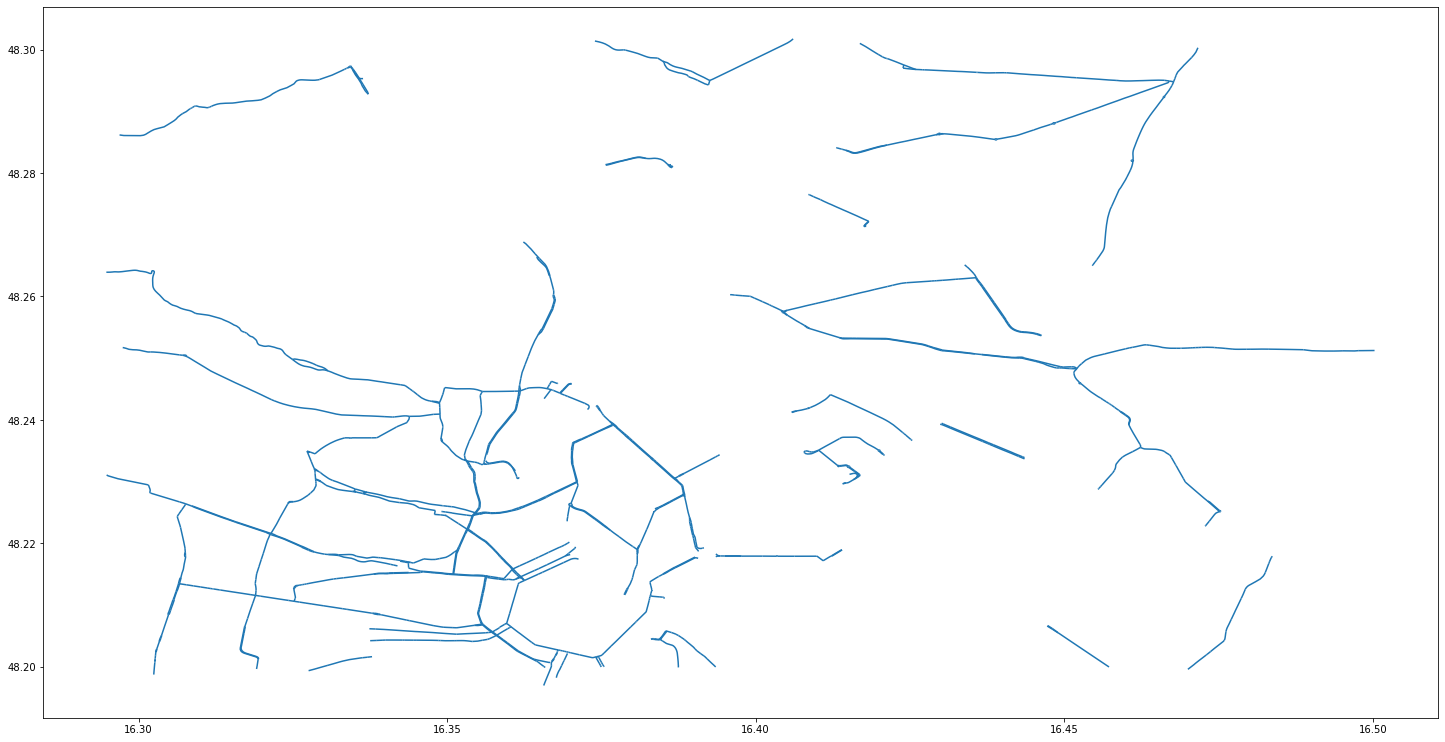

In [454]:
# buffer Float road buffer distance [m]
# bbox List of four coords
# bbox_id Integer processing id of bbox
# osm_value String OSM value
# osm_key String OSM key
# dir_write
#def get_roads():

fwrite = os.path.join(dir_write, create_fname(bbox_id, osm_key))
roads = []
for osm_value in osm_values:
    try:
        roads_osm = get_osm(bbox = bbox, bbox_id = bbox_id, osm_value = osm_value)
    except:
        Warning("'get_osm'" + "failed for bbox_id "+ str(bbox_id) + "osm_value " + osm_value + "osm_key" + osm_key)
    roads.append(roads_osm)
roads_merge = gpd.GeoDataFrame(pd.concat(roads, ignore_index=True), crs=roads[0].crs)
roads_buff = buffer_lines(roads_merge, buffer)
roads_buff.to_file(fwrite, driver = GEOJSON())